In [29]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import datetime
from sklearn.metrics import silhouette_score
# import warnings
# warnings.filterwarnings("always")

In [2]:
DF = pd.read_excel(r'C:\Users\1\Desktop\ТЗ  Datamonsters\DataSet.xlsx')

In [3]:
DF.head()

Чек    Магазин  \
0  Чек 61484 от 01.10.2018 10:05:20  Магазин 1   
1  Чек 61484 от 01.10.2018 10:05:20  Магазин 1   
2  Чек 61484 от 01.10.2018 10:05:20  Магазин 1   
3  Чек 61484 от 01.10.2018 10:05:20  Магазин 1   
4  Чек 61484 от 01.10.2018 10:05:20  Магазин 1   

                       Название товара Вид оплаты   Карта лояльности    Цена  \
0  PL Молоко цельное 1л мдж 3,5% -5,2%       Visa  23489164220602890  118.00   
1               PL Ряженка 4,0% 500 гр       Visa  23489164220602890   67.00   
2                PL Сметана 20% 250 гр       Visa  23489164220602890  119.00   
3                 PL Творог 9% 200 гр        Visa  23489164220602890  109.00   
4           Пакеты "Майка" с логотипом       Visa  23489164220602890    0.01   

   Сумма Итоговая  Сумма скидки  Количество  Сумма скидки без округления  \
0           220.0         16.00         2.0                         16.0   
1            62.0          5.00         1.0                          5.0   
2           112.0          7.00         1.0                          7.0   
3           204.0         14.00         2.0                         14.0   
4             NaN          0.02         2.0                          NaN   

   Сумма округления  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4              0.02

In [4]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257930 entries, 0 to 257929
Data columns (total 11 columns):
Чек                            257930 non-null object
Магазин                        257930 non-null object
Название товара                257930 non-null object
Вид оплаты                     255582 non-null object
Карта лояльности               211663 non-null object
Цена                           257930 non-null float64
Сумма Итоговая                 234340 non-null float64
Сумма скидки                   139399 non-null float64
Количество                     257930 non-null float64
Сумма скидки без округления    90332 non-null float64
Сумма округления               74717 non-null float64
dtypes: float64(6), object(5)
memory usage: 21.6+ MB


In [5]:
DF.describe(include='all')

Чек    Магазин  \
count                             257930     257930   
unique                             57965         14   
top     Чек 68650 от 28.12.2018 13:12:27  Магазин 3   
freq                                 164      60731   
mean                                 NaN        NaN   
std                                  NaN        NaN   
min                                  NaN        NaN   
25%                                  NaN        NaN   
50%                                  NaN        NaN   
75%                                  NaN        NaN   
max                                  NaN        NaN   

                       Название товара     Вид оплаты     Карта лояльности  \
count                           257930         255582               211663   
unique                            4627              7                10408   
top     Сумка ОрганикМаркет 32+19х37см  Visa Electron  2342880000418962890   
freq                              8446         140991                  939   
mean                               NaN            NaN                  NaN   
std                                NaN            NaN                  NaN   
min                                NaN            NaN                  NaN   
25%                                NaN            NaN                  NaN   
50%                                NaN            NaN                  NaN   
75%                                NaN            NaN                  NaN   
max                                NaN            NaN                  NaN   

                 Цена  Сумма Итоговая   Сумма скидки     Количество  \
count   257930.000000   234340.000000  139399.000000  257930.000000   
unique            NaN             NaN            NaN            NaN   
top               NaN             NaN            NaN            NaN   
freq              NaN             NaN            NaN            NaN   
mean       374.893263      324.541496      46.429341       1.242289   
std        580.249707      791.143985     168.548558       5.557604   
min          0.010000        0.010000    -634.360000       0.001000   
25%        109.000000      121.000000       0.460000       1.000000   
50%        175.000000      215.000000      12.000000       1.000000   
75%        429.000000      386.000000      49.000000       1.000000   
max      24390.000000   142100.000000   23266.000000    1500.000000   

        Сумма скидки без округления  Сумма округления  
count                  90332.000000      74717.000000  
unique                          NaN               NaN  
top                             NaN               NaN  
freq                            NaN               NaN  
mean                      71.319419          0.398544  
std                      205.065428          0.308316  
min                     -634.940000          0.010000  
25%                       13.000000          0.090000  
50%                       34.350000          0.400000  
75%                       77.000000          0.650000  
max                    23266.000000          0.990000

In [6]:
'''ОЧИСТКА ДАННЫХ'''

# убираем полные дубликаты
DF1 = DF.drop_duplicates()
# убираем малоинформативные столбцы 
DF1 = DF1.drop(['Сумма скидки без округления', 'Сумма округления'],axis=1) 
# заменяем null значения скидок на 0
DF1['Сумма скидки'].fillna(0, inplace=True)
# заменяем null значения КЛ на "нет данных"
DF1['Карта лояльности'].fillna('нет данных', inplace=True) 
# дропаем отрицательные скидки
DF1 = DF1[DF1['Сумма скидки'] >= 0] 
# дропаем объекты с неизвестной итоговой суммой (более 90% - это "бесплатные" пакеты)
DF1 = DF1[DF1['Сумма Итоговая'] >= 0] 
# убираем подозрительные дубликаты с разными видами оплатами
DF1 = DF1.loc[DF1.drop('Вид оплаты', axis=1).drop_duplicates().index,:] 
# заменяем null значения видов оплаты на наиболее популярный
DF1['Вид оплаты'].fillna(DF1['Вид оплаты'].value_counts().index[0], inplace=True) 

In [7]:
DF1.describe(include='all')

Чек    Магазин       Название товара  \
count                             222102     222102                222102   
unique                             57774         14                  4621   
top     Чек 12271 от 17.11.2018 20:09:16  Магазин 3  PL Творог 9% 200 гр    
freq                                  57      49861                  5484   
mean                                 NaN        NaN                   NaN   
std                                  NaN        NaN                   NaN   
min                                  NaN        NaN                   NaN   
25%                                  NaN        NaN                   NaN   
50%                                  NaN        NaN                   NaN   
75%                                  NaN        NaN                   NaN   
max                                  NaN        NaN                   NaN   

           Вид оплаты Карта лояльности           Цена  Сумма Итоговая  \
count          222102           222102  222102.000000   222102.000000   
unique              7            10405            NaN             NaN   
top     Visa Electron       нет данных            NaN             NaN   
freq           123630            40729            NaN             NaN   
mean              NaN              NaN     411.868820      324.159777   
std               NaN              NaN     597.119782      806.197612   
min               NaN              NaN       0.010000        0.010000   
25%               NaN              NaN     125.000000      122.000000   
50%               NaN              NaN     199.000000      216.000000   
75%               NaN              NaN     488.000000      385.000000   
max               NaN              NaN   24390.000000   142100.000000   

         Сумма скидки     Количество  
count   222102.000000  222102.000000  
unique            NaN            NaN  
top               NaN            NaN  
freq              NaN            NaN  
mean        27.300406       1.230421  
std        133.180393       5.940783  
min          0.000000       0.006000  
25%          0.000000       1.000000  
50%          0.000000       1.000000  
75%         20.000000       1.000000  
max      23266.000000    1500.000000

In [8]:
df_sells = DF1.drop(['Количество'], axis=1).groupby('Чек', as_index= False).agg({
    'Магазин': 'max',
    'Вид оплаты': 'max',
    'Карта лояльности': 'max',
    'Сумма Итоговая': 'sum',
    'Сумма скидки': 'sum',
    'Название товара': 'count',
    'Цена': 'mean'
    })
df_sells.rename({'Название товара':'Pos_amount', 'Цена':'Mean_price_pos'}, axis = 1,inplace=True)
df_sells = df_sells[['Чек', 'Магазин', 'Вид оплаты', 'Карта лояльности', 'Mean_price_pos', 'Pos_amount',
                     'Сумма скидки', 'Сумма Итоговая']]
df_sells2 = df_sells[df_sells['Карта лояльности'] != 'нет данных']

In [9]:
def extract_day(x):
    a = re.search(r'\d{2}.\d{2}.\d{4}', x)[0]
    a = time.mktime(datetime.datetime.strptime(a, "%d.%m.%Y").timetuple())
    return a
def extract_time(x):
    tmp = re.search(r'\d+:\d{2}:\d{2}', x)[0]
    return re.search(r'\d+', tmp)[0]
def extract_check_number(x):
    return re.search(r'Чек \d+', x)[0][4:]
def shop_view(x):
    if 'Онлайн' in x:
        return '0'
    else:
        return re.search(r'Магазин \d+', x)[0][8:]
def day_delta(x):
    return x.max_day-x.min_day

In [10]:
"""Достаем время/дату, уникальные номера чеков"""
df_sells2.loc[:,'Date'] = df_sells2['Чек'].apply(extract_day)
df_sells2.loc[:,'Hour'] = df_sells2['Чек'].apply(extract_time)
df_sells2.loc[:,'Shop'] = df_sells2['Магазин'].apply(shop_view)
df_sells2.loc[:,'Unique_Check'] = df_sells2['Чек'].apply(extract_check_number)+'_'+df_sells2['Shop']+'_'+df_sells2['Hour']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
df_sells2.loc[:,'Recency'] = ((df_sells2.loc[:, 'Date'].max() - df_sells2.loc[:, 'Date'])/3600/24).astype(int)

In [12]:
df_sells2.sample(5)

Чек    Магазин     Вид оплаты  \
14235  Чек 18007 от 06.11.2018 15:59:56  Магазин 2  Visa Electron   
54698  Чек 86727 от 20.12.2018 16:33:34  Магазин 3       Наличные   
46607  Чек 73239 от 25.12.2018 14:14:33  Магазин 8  Visa Electron   
37192  Чек 65109 от 27.10.2018 15:28:35  Магазин 8       Наличные   
16106  Чек 20193 от 17.12.2018 14:49:16  Магазин 2  Visa Electron   

          Карта лояльности  Mean_price_pos  Pos_amount  Сумма скидки  \
14235    23489605448639890       75.333333           3         112.0   
54698  2342880100559657890       54.000000           1           0.0   
46607    23489154250033890      193.250000           4          38.0   
37192    23489031445070890      350.857143           7           0.0   
16106  2342880100531776890       77.000000           1           0.0   

       Сумма Итоговая          Date Hour Shop Unique_Check  Recency  
14235           114.0  1.541452e+09   15    2   18007_2_15       55  
54698            54.0  1.545253e+09   16    3   86727_3_16       11  
46607           735.0  1.545685e+09   14    8   73239_8_14        6  
37192          2775.0  1.540588e+09   15    8   65109_8_15       65  
16106           154.0  1.544994e+09   14    2   20193_2_14       14

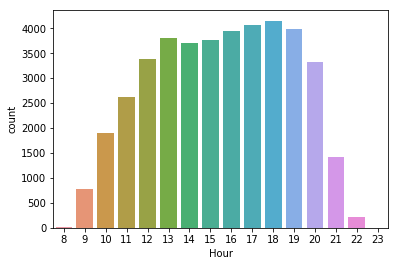

In [13]:

sns.countplot(df_sells2.Hour.astype(int).sort_values());

In [14]:
# корректируем значение часов - с 23 на 22, т.к. всего 4 значеия в начале 24 часа - это вероятнее всего ошибка на кассе
df_sells2.Hour.loc[df_sells2.Hour == '23',] = 22
# 8 комбинируем с 9-ю т.к. количество покупок в это время тоже подозрительно мало и не вносит сколько-нибудь ощитимого вклада
df_sells2.Hour.loc[df_sells2.Hour == '8',] = 9

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


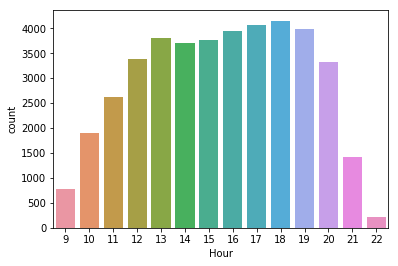

In [15]:
df_sells2.Hour = df_sells2.Hour.astype(int)
sns.countplot(df_sells2.Hour.sort_values());

In [134]:
df_sells3 = df_sells2.drop(['Вид оплаты','Магазин', 'Вид оплаты','Date', 'Shop', 'Unique_Check'], axis=1).groupby(
    'Карта лояльности', as_index= False).agg({
    'Recency': 'min',
    'Чек': 'count',
    'Сумма Итоговая': 'sum',
    'Mean_price_pos': 'mean',
    'Pos_amount': 'mean',
    'Сумма скидки': 'sum',
    'Hour': 'mean'
    })
df_sells3.rename({'Чек':'Frequency', 'Сумма Итоговая':'Monetary', 'Pos_amount': 'Mean_amount'}, axis = 1,inplace=True)
#Считаем lifetime для будущих расчетов 
Max_date = df_sells2[['Карта лояльности', 'Recency']].groupby('Карта лояльности', as_index= False).agg({'Recency': 'max'}).rename({'Recency':'Lifetime'}, axis=1)
df_sells3 = df_sells3.merge(Max_date['Lifetime'], left_index=True, right_index=True)
df_sells3['Lifetime'] = df_sells3['Lifetime'] - df_sells3['Recency']+1
print(df_sells3.shape)

(10404, 9)


In [135]:
df_sells3.head()

Карта лояльности  Recency  Frequency  Monetary  Mean_price_pos  \
0  2342880000027812890       49          1    2171.0      994.250000   
1  2342880000031512890        4          2    1028.0     1834.500000   
2  2342880000034766890       56          1     458.0      229.000000   
3  2342880000038894890       51          4    1630.0      115.285714   
4  2342880000416180890       53          5    2780.0      811.066667   

   Mean_amount  Сумма скидки   Hour  Lifetime  
0         4.00          1.59  20.00         1  
1         1.50          0.76  14.50         5  
2         2.00          0.00  13.00         1  
3         2.75          3.13  11.75        23  
4         1.60        537.09  10.40        23

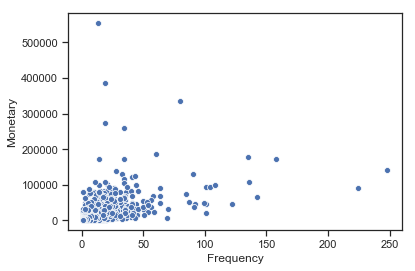

In [129]:
sns.scatterplot('Frequency', 'Monetary', data=df_sells3);

In [130]:
# drop outliers in Frequency and Monetary (about +- 3 sigma)
f_low = df_sells3["Frequency"].quantile(0.01)
f_hi  = df_sells3["Frequency"].quantile(0.99)
print('f_low={}'.format(f_low), 'f_hi={}'.format(f_hi))
m_low = df_sells3["Monetary"].quantile(0.01)
m_hi  = df_sells3["Monetary"].quantile(0.99)
print('m_low={}'.format(m_low), 'm_hi={}'.format(m_hi))

df_sells_out = df_sells3[(df_sells3["Frequency"] <= f_hi) & (df_sells3["Frequency"] >= f_low)]
df_sells_out = df_sells_out[(df_sells_out["Monetary"] <= m_hi) & (df_sells_out["Monetary"] >= m_low)]
print('Removed {} outliers'.format(df_sells3.shape[0] - df_sells_out.shape[0]), 
      'Data dimension: {}'.format(df_sells_out.shape), sep='\n')

f_low=1.0 f_hi=31.0
m_low=80.03 m_hi=54929.91999999991
Removed 273 outliers
Data dimension: (10131, 9)


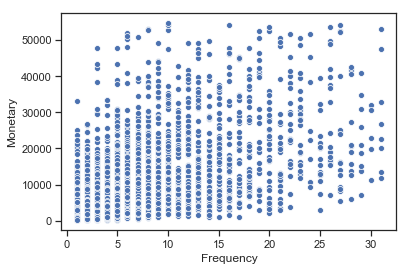

In [131]:
sns.scatterplot('Frequency', 'Monetary', data=df_sells_out);

In [132]:
# fig, ax = plt.subplots(2,3, figsize=(18,5))
# sns.set(style="ticks")

# g1 = sns.countplot(df_sells_out.Recency, ax=ax[0,1])
# g2 = sns.countplot(df_sells_out.Frequency[df_sells_out.Frequency > 1], ax=ax[1,0])
# g3 = sns.distplot(df_sells_out.Monetary, ax=ax[1,1])


In [133]:
def dev_recency(x):
    if x <= 3:
        return 1
    elif x <= 7:
        return 2
    elif x <= 14:
        return 3
    elif x <= 30:
        return 4
    else:
        return 5
def dev_frequency(x):
    if x <= 2:
        return 5
    elif x <= 6:
        return 4
    elif x <= 12:
        return 3
    elif x <= 24:
        return 2
    else:
        return 1
def dev_monetary(x):
    if x <= 2000:
        return 5
    elif x <= 5000:
        return 4
    elif x <= 10000:
        return 3
    elif x <= 25000:
        return 2
    else:
        return 1

In [23]:
df_RFM = df_sells_out[['Recency', 'Frequency', 'Monetary']]
df_RFM['Recency_s'] = df_RFM.Recency.apply(dev_recency)
df_RFM['Frequency_s'] = df_RFM.Frequency.apply(dev_frequency)
df_RFM['Monetary_s'] = df_RFM.Monetary.apply(dev_monetary)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [44]:
k_means = KMeans(n_clusters=9, n_init=30, max_iter=500)

In [45]:
pred = k_means.fit_predict(df_RFM[['Recency_s', 'Frequency_s', 'Monetary_s']])
df_RFM['Cluster'] = pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
sns.scatterplot?

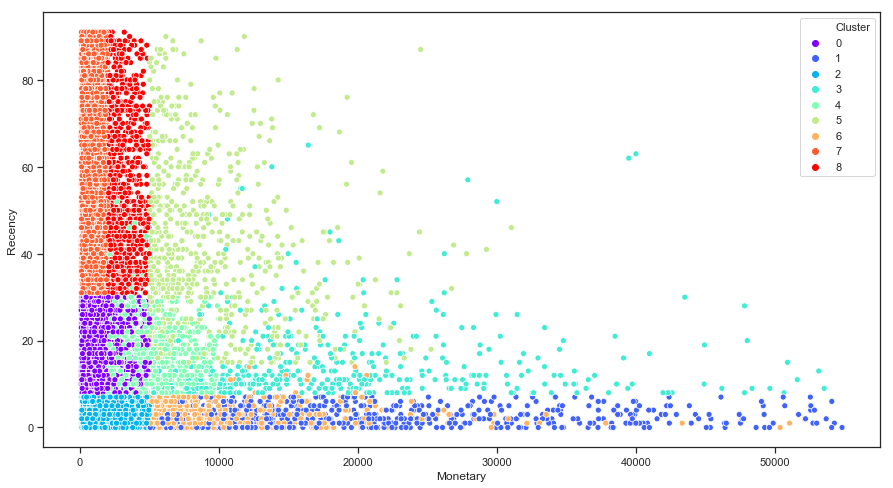

In [53]:
plt.figure(figsize=(15,8))
sns.scatterplot('Monetary', 'Recency', data=df_RFM, hue='Cluster', palette='rainbow', legend='full');

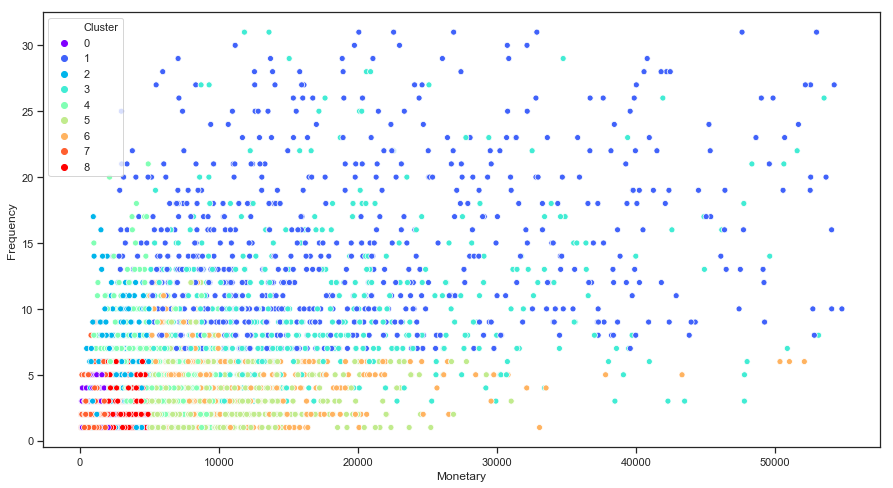

In [192]:
plt.figure(figsize=(15,8))
sns.scatterplot('Monetary', 'Frequency', data=df_RFM, hue='Cluster', palette='rainbow', legend='full');

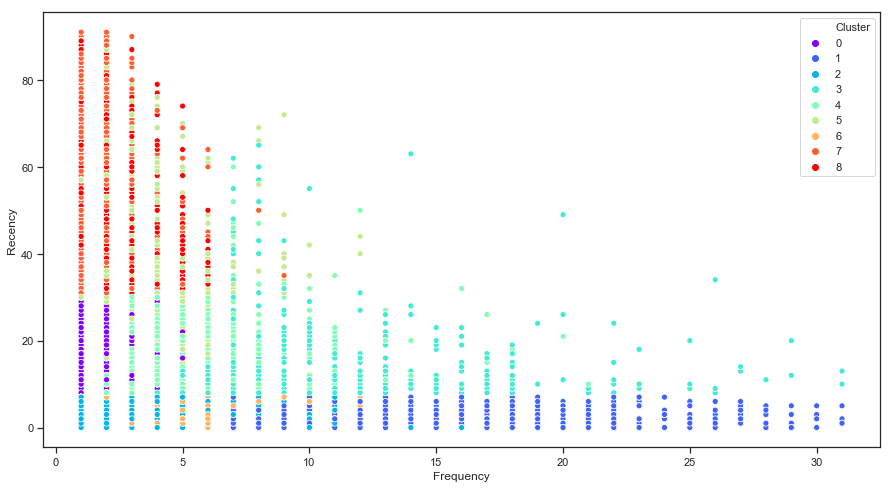

In [193]:
plt.figure(figsize=(15,8))
sns.scatterplot('Frequency', 'Recency', data=df_RFM, hue='Cluster', palette='rainbow', legend='full');

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


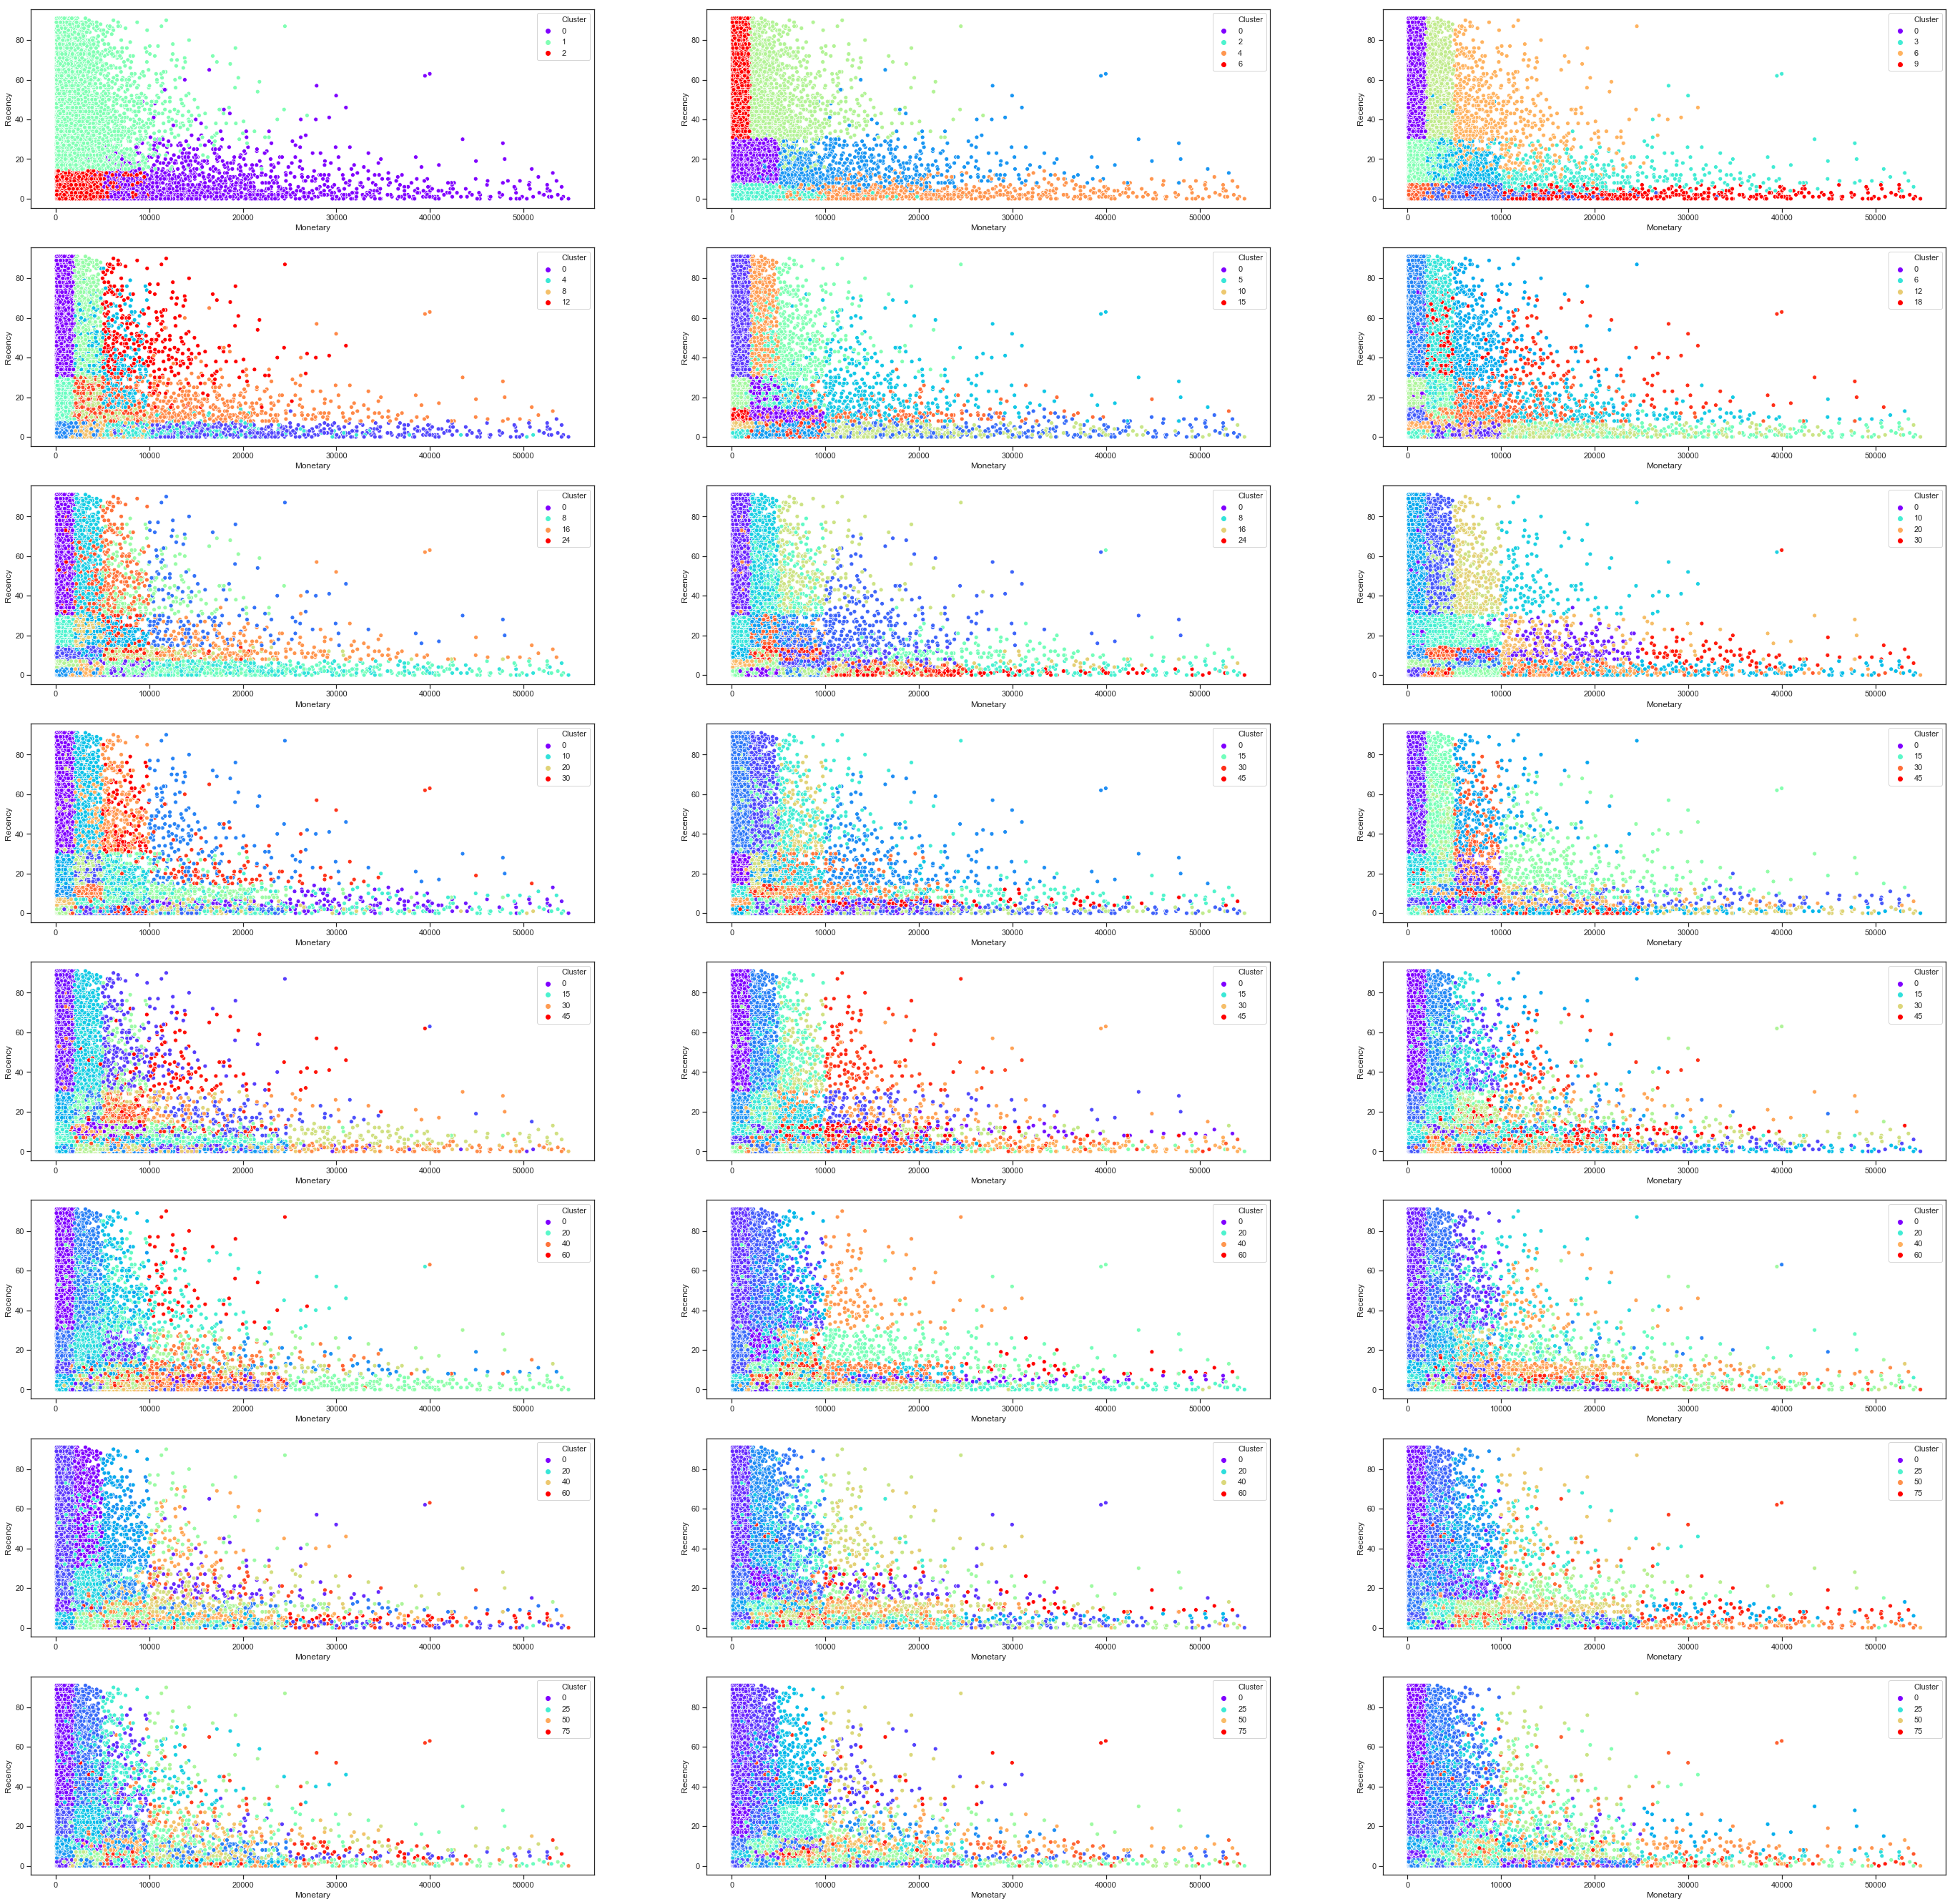

In [33]:
fig, ax = plt.subplots(8,3, figsize=(48,48))
sns.set(style="ticks")
c = 0
s_score = dict()
for i in range(8):
    for j in range(3):
        k_means = KMeans(n_clusters=c+3, n_init=30, max_iter=500)
        pred = k_means.fit_predict(df_RFM.loc[:,['Recency_s', 'Frequency_s', 'Monetary_s']])
        df_RFM.loc[:,'Cluster'] = pred
        s_score.update({c+3: silhouette_score(df_RFM.loc[:,['Recency_s', 'Frequency_s', 'Monetary_s']], pred)})
        sns.scatterplot('Monetary', 'Recency', data=df_RFM, hue='Cluster', palette='rainbow', ax=ax[i,j])
        c += 3

In [63]:
# sns.lineplot(list(s_score.keys()), list(s_score.values()));
pd.merge?

In [137]:
df_clastered = df_RFM.merge(df_sells_out['Карта лояльности'], left_index=True, right_index=True)
df_clastered = df_clastered.merge(df_sells_out['Lifetime'], left_index=True, right_index=True)
df_clastered.head()

Recency  Frequency  Monetary  Recency_s  Frequency_s  Monetary_s  Cluster  \
0       49          1    2171.0          5            5           4        8   
1        4          2    1028.0          2            5           5        2   
2       56          1     458.0          5            5           5        7   
3       51          4    1630.0          5            4           5        7   
4       53          5    2780.0          5            4           4        8   

      Карта лояльности  Lifetime  
0  2342880000027812890         1  
1  2342880000031512890         5  
2  2342880000034766890         1  
3  2342880000038894890        23  
4  2342880000416180890        23

In [191]:
df_clastered[['Recency', 'Cluster']].groupby('Cluster').count()

Recency
Cluster         
0           1862
1            687
2           1167
3            427
4            758
5            697
6            445
7           3086
8           1002

In [138]:
analytic1 = df_clastered.drop(['Recency_s', 'Frequency_s', 'Monetary_s'], axis=1).groupby('Cluster').mean()
display(analytic1)
print('Recency mean: {}'.format(df_clastered.Recency.mean()),
     'Frequency mean: {}'.format(df_clastered.Frequency.mean()),
     'Monetary mean: {}'.format(df_clastered.Monetary.mean()), 
      'Lifetimemean: {}'.format(df_clastered.Lifetime.mean()), sep='\n')

Recency  Frequency      Monetary   Lifetime
Cluster                                               
0        18.564984   1.549946   1379.712137  12.714286
1         2.576419  14.567686  19561.569141  73.982533
2         3.154242   2.771208   1965.823479  27.203085
3        15.309133  10.494145  18634.838407  59.812646
4        17.361478   5.013193   4796.976253  47.765172
5        41.882353   2.738881   9325.021521  21.047346
6         3.397753   4.249438  10724.703371  46.719101
7        58.780298   1.279002    829.233960   4.139663
8        54.092814   1.919162   3123.225549  11.469062

Recency mean: 32.180140163853515
Frequency mean: 3.3638337775145595
Monetary mean: 4624.977099990129
Lifetimemean: 22.47744546441615


In [160]:
#ГЛАВНАЯ АНАЛИТИЧЕСКАЯ ТАБЛИЦА
tmp = df_clastered[['Cluster','Monetary']].groupby('Cluster').sum().rename({'Monetary':'Summa'}, axis=1)
tmp['Amount'] = df_clastered[['Cluster','Monetary']].groupby('Cluster').count()
analytic1['ARPU'] = tmp['Summa']/tmp['Amount']/92
analytic1['LTV'] = analytic1['Lifetime']*analytic1['ARPU']
analytic1

Recency  Frequency      Monetary   Lifetime        ARPU  \
Cluster                                                              
0        18.564984   1.549946   1379.712137  12.714286   14.996871   
1         2.576419  14.567686  19561.569141  73.982533  212.625752   
2         3.154242   2.771208   1965.823479  27.203085   21.367647   
3        15.309133  10.494145  18634.838407  59.812646  202.552591   
4        17.361478   5.013193   4796.976253  47.765172   52.141046   
5        41.882353   2.738881   9325.021521  21.047346  101.358930   
6         3.397753   4.249438  10724.703371  46.719101  116.572863   
7        58.780298   1.279002    829.233960   4.139663    9.013413   
8        54.092814   1.919162   3123.225549  11.469062   33.948104   

                  LTV  
Cluster                
0          190.674503  
1        15730.591627  
2          581.265901  
3        12115.206520  
4         2490.526016  
5         2133.336437  
6         5446.179362  
7           37.312491  
8          389.352903

In [173]:
analytic1[['Lifetime', 'LTV']].round(2)

Lifetime       LTV
Cluster                    
0           12.71    190.67
1           73.98  15730.59
2           27.20    581.27
3           59.81  12115.21
4           47.77   2490.53
5           21.05   2133.34
6           46.72   5446.18
7            4.14     37.31
8           11.47    389.35

In [163]:
#Средний общий LTV
df_clastered['Monetary'].sum()/df_clastered['Monetary'].count()*df_clastered['Lifetime'].mean()/92

1129.9746797739315